<a href="https://colab.research.google.com/github/A-R-Yazdi/Remote-communities-/blob/EDA_LingJun/Multivariate_Data_Analysis_LingJun_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load data & packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# input dataset
input_file = "/content/drive/MyDrive/Colab Notebooks/data/all_combined_training.csv"
validation_file = "/content/drive/MyDrive/Colab Notebooks/data/all_combined_validation.csv"
model_root= "/content/drive/MyDrive/Colab Notebooks/models/"
data_root="/content/drive/MyDrive/Colab Notebooks/data/"
fig_root='/content/drive/MyDrive/Colab Notebooks/figs/'
package_root='/content/drive/MyDrive/Colab Notebooks/packages/'
root='/content/drive/MyDrive/Colab Notebooks/'

DEBUG_MODE = True

In [ ]:
# %%capture suppresses the large output
%%capture
!pip install matplotlib>=3.1.3
!pip install statsmodels>=0.12.2
!pip install sktime
!pip install pmdarima>=1.8.2
!pip install sktime[all_extras]

In [ ]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load

sns.set()
plt.style.use('bmh')

In [ ]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()
dfc['datetime'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
dfc['kw_cap'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
183429,2015,12,9,21,2685.916667,58.10006,-68.40612,2754,3291.582628,-8.186865,2015-12-09 21:00:00,2015-12-09,0.975278
36663,2014,3,9,15,1108.780917,58.45424,-78.10301,1757,1662.384400,-23.323676,2014-03-09 15:00:00,2014-03-09,0.631065


## Load Preprocessing class

In [ ]:
import pandas as pd

class Preprocessing:
    def __init__(self):
        pass
    
    def create_key(self, keyString='df', keyRange=9):
        """ create a list of dataframe names, key=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9']
        keyString is the invariable in the key, e.g. 'df' in 'df1'
        """
        key=[]
        for i in range(9):
            key.append(keyString+str(i+1))
        return key

    dfc = None
    def create_valuelist(self, DF=dfc, col='lat'):
        list_of_df= []
        col_val_list = list(DF[col].value_counts().keys())
        # print(col_val_list)
        for col_val in col_val_list:
            list_of_df.append(DF[DF[col]==col_val].reset_index(drop=True))
        return list_of_df


    def load_n_sort(self, df='df2'):
        df = pd.read_csv(data_root+df+".csv", index_col = 0)
        df = df.sort_values(by='datetime', ascending=True)
        return df


    def load_dframes(self, df_name='df', prop="", df_enum_range=range(1,10)):
        # print('preloading')
        if isinstance(df_enum_range, range) and isinstance(df_name, str):
            # print("loading....")
            for i in df_enum_range:
              n = df_name+str(i)+prop
              # use globals() to convert a string into var name so that we can use later
              globals()[n] = self.load_n_sort(n)
        
        # show the dfs are loaded
        for i in range(1,10):
          if 'df'+str(i) in globals().keys():
            print('df'+str(i)+" is loaded")
    
    def show_missing_datetime(self, diff_from: pd.DataFrame, start_d="2013-01-01", end_d="2016-01-01", freq='H'):
        """input var diff_from has to be a DataFrame with no duplications"""
        if isinstance(diff_from, pd.DataFrame) and len(diff_from[diff_from.duplicated()])==0:
            diff_from['datetime'] = pd.to_datetime(diff_from['datetime'])
            diff = pd.date_range(start=start_d, end=end_d, freq=freq)[:-1].difference(diff_from['datetime'])
            return diff
    
    def fill_missing_rows(self, df=None):
        """input must be a dataframe"""
        if isinstance(df, pd.DataFrame):
            df['datetime'] = pd.to_datetime(df['datetime'])
            additional_df = pd.DataFrame(index=self.show_missing_datetime(diff_from=df), columns=df.columns)
            df = df.set_index('datetime').append(additional_df).sort_index(ascending=True).ffill().reset_index()
            df['datetime'] = df['index']
        
        return df.drop(['index'], axis=1)

    def show_shape(self, df_name='df', iterate=range(1,10), prop=""):
        shape = []
        for i in iterate:
            # name = 'df'+str(i) 
            name = globals()[df_name+str(i)+prop]
            shape.append(name.shape)
        df = pd.DataFrame(shape, columns=['num_of_rows', 'num_of_cols'], index = [df_name+str(i)+prop for i in range(1,10)])
        return df
    
    df3 = None
    def show_outliers(self, df=df3, col_name='kw_cap', num_of_std=3, anomaly_window=24*365*3):
        """
        df needs to be a DataFrame, col_name needs to be a string, num_of_std is an integer
        num_of_std decides the window of NORMAL values
        anomaly_window is the window size from which we decide the mean, std
        """
        # if isinstance(df, pd.DataFrame) & isinstance(col_name, str) & isinstance(num_of_std, int):
        #   pass
        # else:
        #   print("params need to be the correct type")
        
        d_outliers = pd.DataFrame(columns=df.columns)
        
        # if the row number is less than anomaly_window, take the first anomaly_window number of rows and calculate the mean, std
        dd = df[:anomaly_window]
        d_mean = dd[col_name].mean()
        d_std = dd[col_name].std()
        low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
        d_outliers = pd.concat([d_outliers, dd[(dd[col_name]< low) | (dd[col_name] > high)]])

        # if anomaly_window < len(df), this means d_mean, d_std changes row by row after we go beyond row number anomaly_window
        dd = df[anomaly_window:]
        for row in range(anomaly_window, len(df)):
            d_mean = df[col_name][row-anomaly_window:row].mean()
            d_std = df[col_name][row-anomaly_window:row].std()
            low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
            if (dd[col_name][row]<low)|(dd[col_name][row]>high):
              d_outliers = pd.concat([d_outliers, df[row:row+1]])

        return d_outliers

    def replace_outliers(self, df=df3, col_name: str='kw_cap', num_of_std : int=3, anomaly_window : int =24*365*3):
        """
        df needs to be a DataFrame, col_name needs to be a string, num_of_std is an integer
        num_of_std decides the window of NORMAL values
        anomaly_window is the window size from which we decide the mean, std
        """
        # index is the outliers row number
        index =  self.show_outliers(df=df, col_name=col_name, anomaly_window=anomaly_window, num_of_std=num_of_std).index
        
        for i in index:

            if i < anomaly_window:
            # if the row number is less than anomaly_window, take the first anomaly_window number of rows and calculate the mean, std
              dd = df[:anomaly_window]
              d_mean = dd[col_name].mean()
              d_std = dd[col_name].std()
              low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
              df[col_name][i] = d_mean
            
            else:
              dd = df[anomaly_window:]
              for row in range(anomaly_window, len(df)):
                  d_mean = df[col_name][row-anomaly_window:row].mean()
                  d_std = df[col_name][row-anomaly_window:row].std()
                  low, high = d_mean -(num_of_std * d_std), d_mean + (num_of_std * d_std)
                  df[col_name][i] = d_mean

        return df

In [ ]:
Preprocessing =  Preprocessing()

## Hourly resolution

In [ ]:
Preprocessing.load_dframes(df_name='df', prop="_processed")
Preprocessing.show_shape(df_name='df', prop="_processed")

,num_of_rows,num_of_cols
df1_processed,26280,13
df2_processed,26280,13
df3_processed,26280,13
df4_processed,26280,13
df5_processed,26280,13
df6_processed,26280,13
df7_processed,26280,13
df8_processed,26280,13
df9_processed,26280,13


In [ ]:
df1_processed.columns

Index(['year', 'month', 'day', 'hour', 'Kw', 'lat', 'lon', 'population',
       'annual_peak_load', 'Temp (°C)', 'date', 'kw_cap', 'datetime'],
      dtype='object')

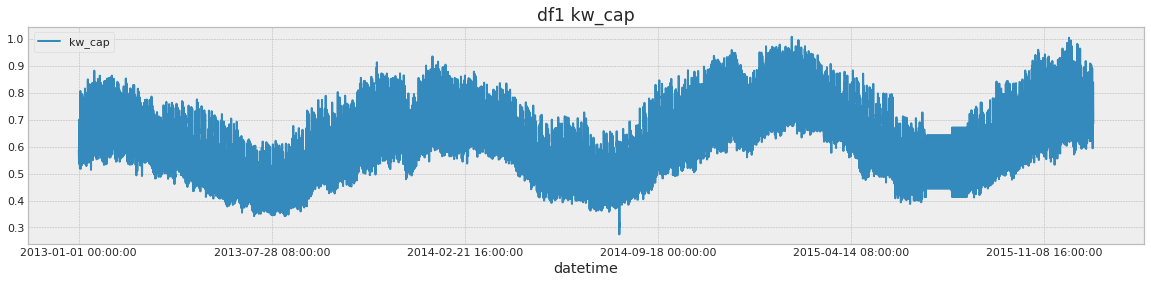

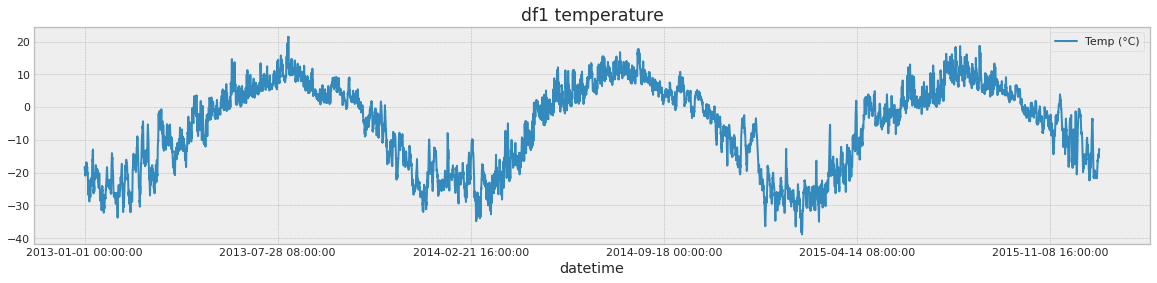

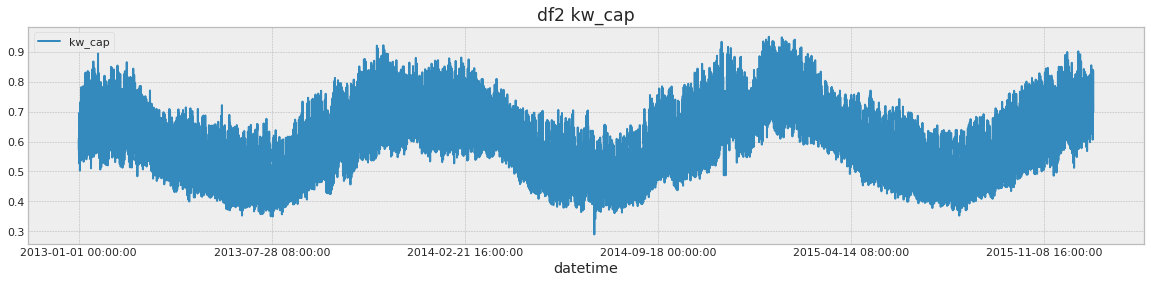

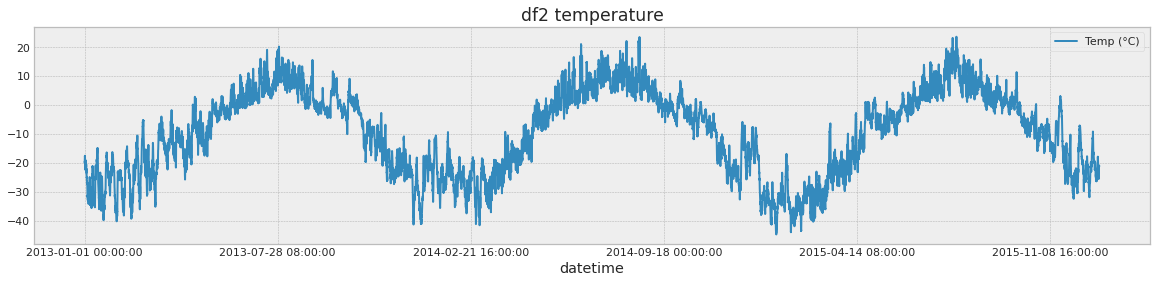

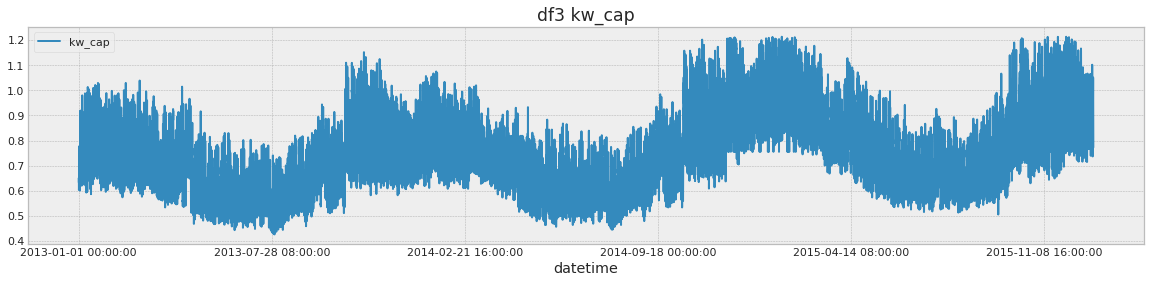

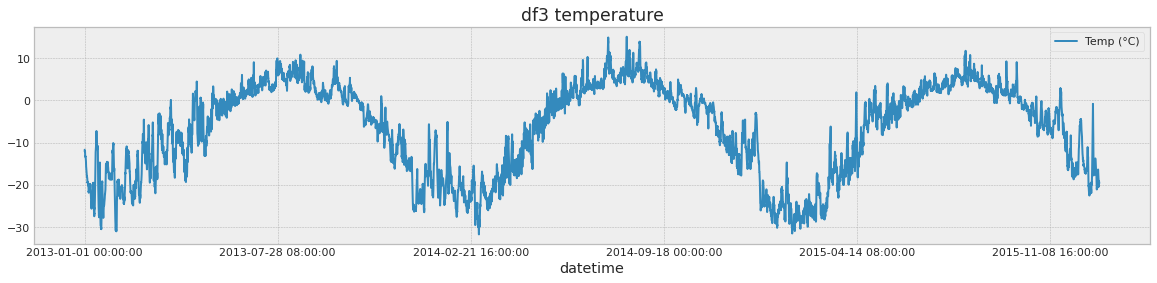

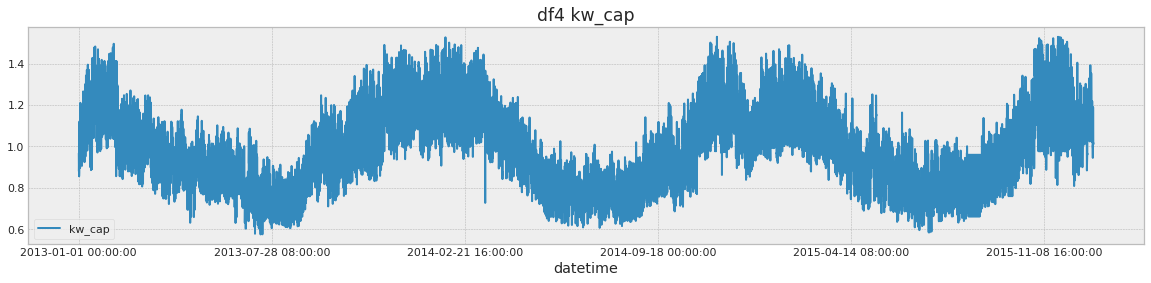

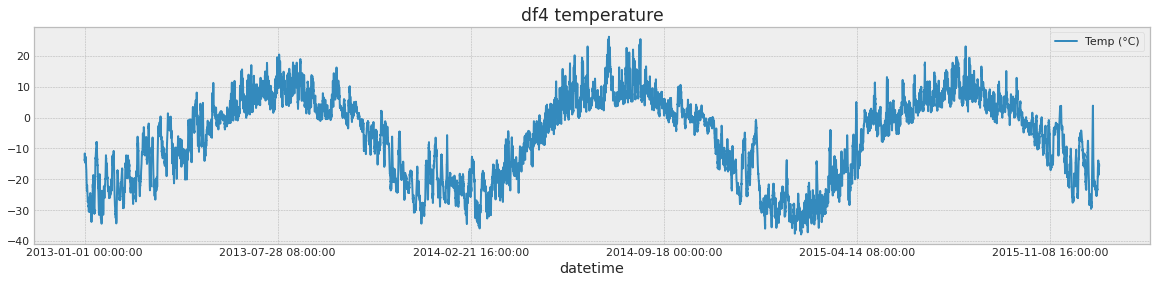

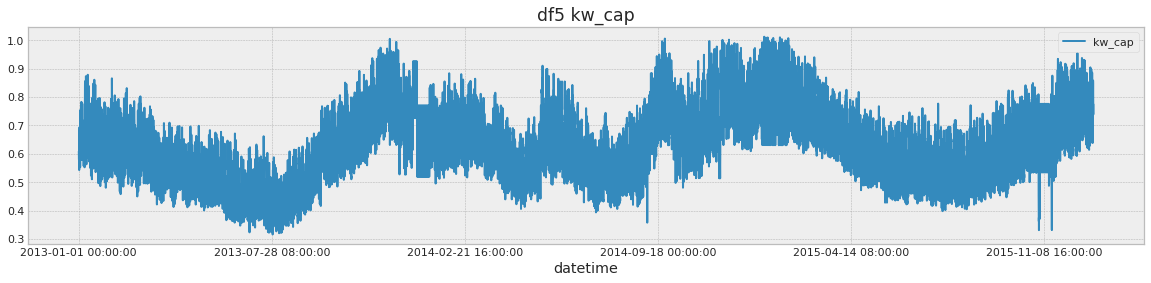

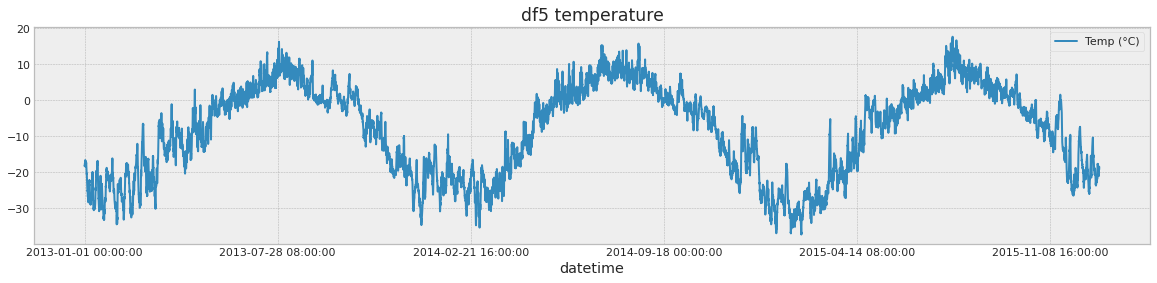

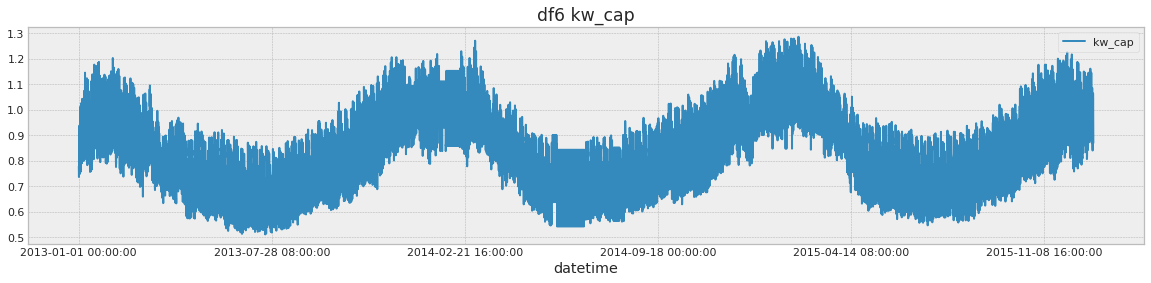

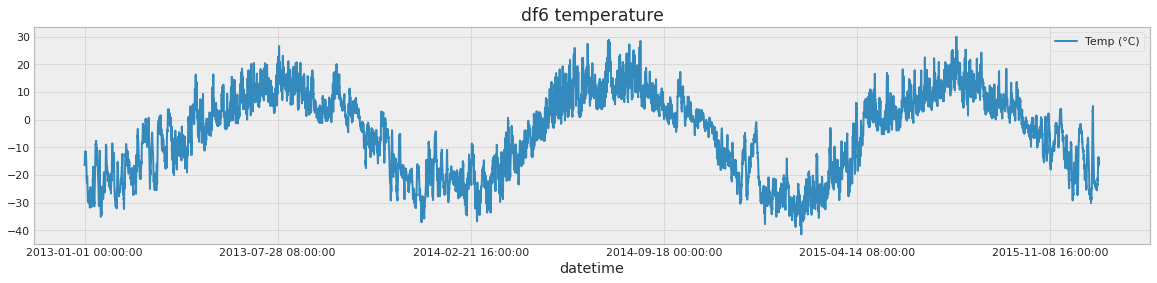

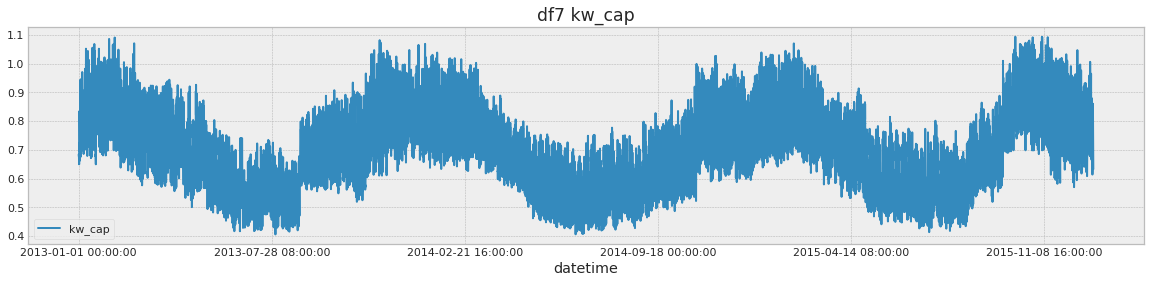

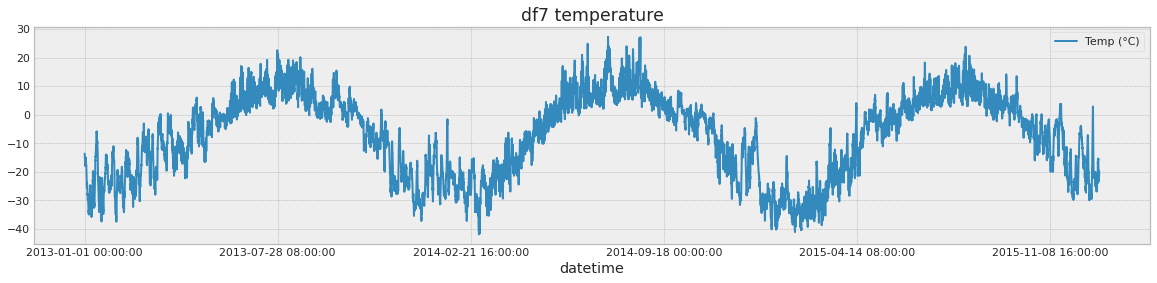

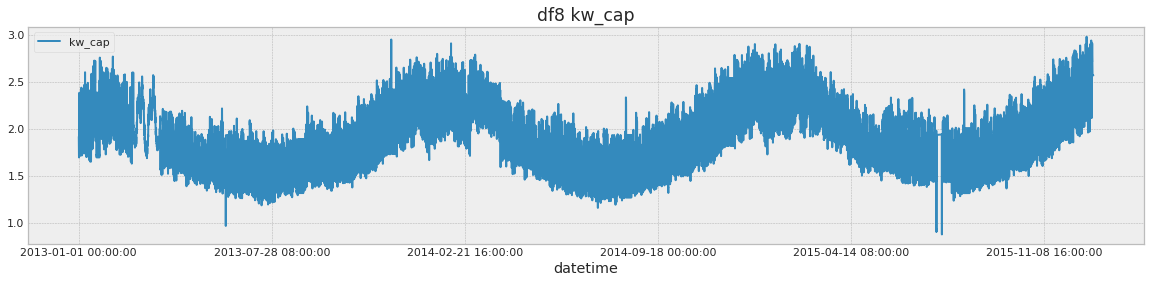

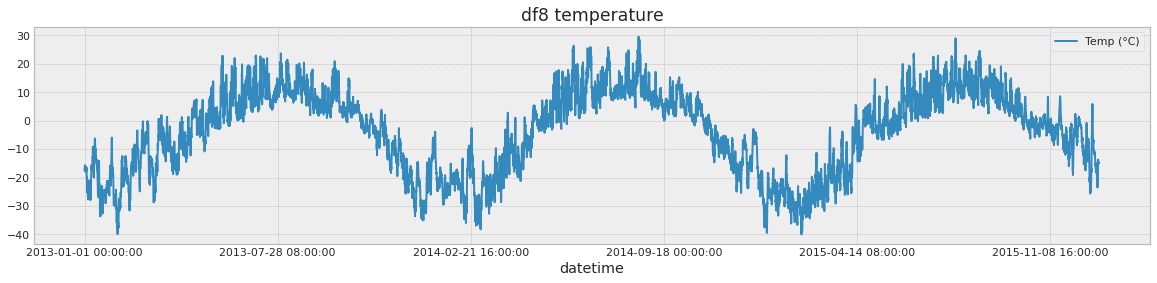

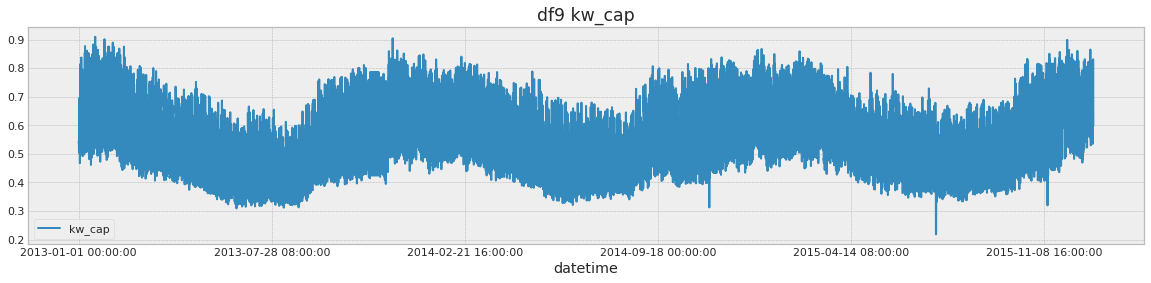

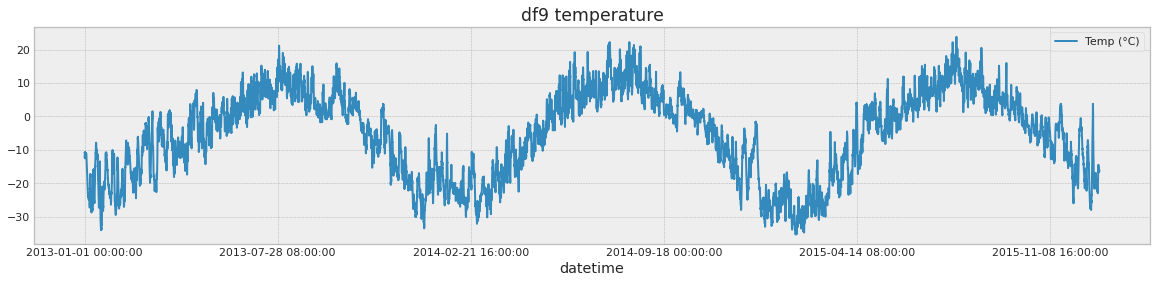

In [ ]:
import statsmodels.api as sm

def plot_dfs(rang=range(1,10)):
  if not isinstance(rang, range):
    print('rang need to be a range object')
  for i in rang:
    data = globals()['df'+str(i)+"_processed"][['datetime', 'kw_cap']].set_index('datetime')
    fig = data.plot(figsize=(20, 4), title='df'+str(i)+" kw_cap")
    # fig.savefig(fig_root+'df'+str(i)+'.png')
    # print(fig)

    temp_data = globals()['df'+str(i)+"_processed"][['datetime', 'Temp (°C)']].set_index('datetime')
    fig = temp_data.plot(figsize=(20, 4), title='df'+str(i)+" temperature")
    # use a print() statement will print: 'AxesSubplot' object ......(something something)
    # print(fig)
    plt.show()

plot_dfs(rang=range(1,10))

## Scale and standardize the data

__The `temperature` and `kw_cap` seem *VERY* correlated__: but let's transform the two series before calculating the correlation. How about we scale them to `[0,1]`? 

In [ ]:
# print(scaler.data_max_)
# print(scaler.transform(data))
# print(scaler.transform([[2, 2]]))
!python --version

Python 3.7.13


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale_series(cols: [str], cols_scaler_range=[tuple], df='df', df_indices=range(1,10), prop="_processed", DEBUG_MODE=False):
  """
  cols are a list strings, they are the dataframe column names; 
  cols_scaler_range are a list of tuples, they are the range we want to scale the cols to.  
  cols_scaler_range must have the same length as cols.
  """
  assert all(isinstance(s, str) for s in cols)
  assert all(isinstance(s, tuple) for s in cols_scaler_range)

  for i in df_indices:
    dic = {}
    for j in range(len(cols)):
      data = globals()[df+str(i)+prop][cols[j]].values
      # reshape to (n_sample, n_features)
      data = data.reshape(len(data), 1)
      data_scaler = MinMaxScaler(feature_range=cols_scaler_range[j])
      data_scaler = data_scaler.fit(data)

      data_normalized = pd.Series(data_scaler.transform(data).reshape(len(data)))
    
      dic[cols[j]] = data_normalized
      # Concatenating the series side by side as depicted by axis=1  
      globals()['df'+str(i)+"_scaled"] = pd.concat(dic, axis = 1)

      if DEBUG_MODE:
      
        print(cols[j]+' Min: %f, Max: %f' % (data_scaler.data_min_, data_scaler.data_max_))
        print()

In [ ]:
# scale_series(cols=[56 , 'Temp (°C)'], cols_scaler_range=[(0,1), (0, 0.7)], DEBUG_MODE=False)
scale_series(cols=['kw_cap', 'Temp (°C)'], cols_scaler_range=[(0,1), (0, 0.7)], DEBUG_MODE=False)
df6_scaled

,kw_cap,Temp (°C)
0,0.343768,0.246795
1,0.337212,0.247528
2,0.323786,0.245084
3,0.303804,0.263264
4,0.290383,0.267925
...,...,...
26275,0.602069,0.261174
26276,0.557893,0.259547
26277,0.515513,0.255094
26278,0.463689,0.257842


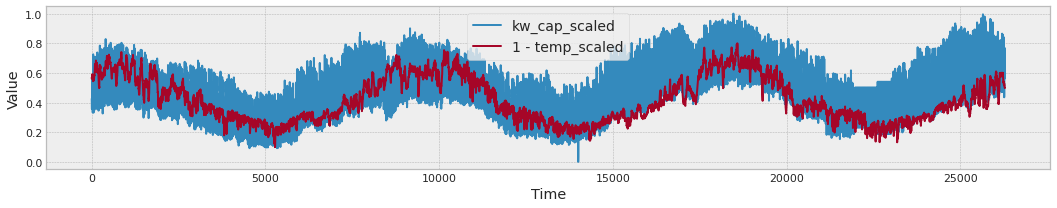

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

plt.figure(figsize=(18, 3))
plot_series(range(len(df1_scaled.kw_cap)), df1_scaled.kw_cap, label="kw_cap_scaled")
plot_series(range(len(df1_scaled['Temp (°C)'])), 0.8-df1_scaled['Temp (°C)'], label=f"1 - temp_scaled")

__Standardize the data__

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

def standardize_series(cols: [str], df='df', df_indices=range(1,10), prop="_processed", DEBUG_MODE=False):
  """
  cols are a list strings, they are the dataframe column names; 
  cols_scaler_range are a list of tuples, they are the range we want to scale the cols to.  
  cols_scaler_range must have the same length as cols.
  """
  assert all(isinstance(s, str) for s in cols)

  for i in df_indices:
    dic = {}
    for j in range(len(cols)):
      data = globals()[df+str(i)+prop][cols[j]].values
      data = data.reshape(len(data), 1)
      
      scaler = StandardScaler()
      scaler = scaler.fit(data)
      
      if DEBUG_MODE:
        print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

      normalized = scaler.transform(data)
      data_normalized = pd.Series(scaler.transform(data).reshape(len(data)))
    
      dic[cols[j]] = data_normalized
      # Concatenating the series side by side as depicted by axis=1  
      globals()['df'+str(i)+"_stdard"] = pd.concat(dic, axis = 1)
    
    print()


In [ ]:
standardize_series(cols=['kw_cap', 'Temp (°C)'], df_indices=range(1,3), DEBUG_MODE=True)

Mean: 0.631547, StandardDeviation: 0.126836
Mean: -5.730700, StandardDeviation: 12.748533

Mean: 0.613737, StandardDeviation: 0.112319
Mean: -9.438642, StandardDeviation: 14.322398



__Sanity check__: verify that the data is standardized

In [ ]:
dd = df2_stdard['kw_cap'].values.reshape(len(df2_stdard),1)
scaler = StandardScaler()
scaler = scaler.fit(dd)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

Mean: -0.000000, StandardDeviation: 1.000000


In [ ]:
df1_stdard.head()

## Let's find the correlation between two variables

In [ ]:
df1_stdard.corr()

,kw_cap,Temp (°C)
kw_cap,1.000000,-0.559777
Temp (°C),-0.559777,1.000000


In [ ]:
df1_processed[['kw_cap','Temp (°C)','year','month','day','hour']].corr(method ='pearson')

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


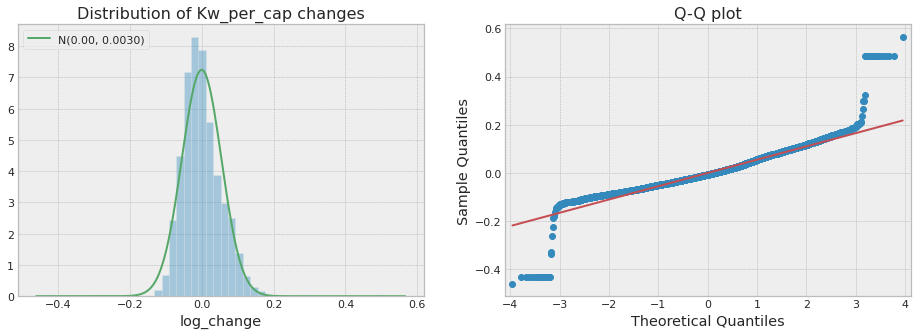

In [ ]:
import scipy.stats as scs

d_series = df1_processed['kw_cap']
df1_processed['log_change'] = np.log(d_series/d_series.shift(1))
r_range = np.linspace(min(df1_processed['log_change'].dropna()), max(df1_processed['log_change'].dropna()), num=1000)
mu = df1_processed['log_change'].dropna().mean()
sigma = df1_processed['log_change'].dropna().std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#Plot the histogram and the Q-Q plot
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# histogram
sns.distplot(df1_processed['log_change'].dropna(), kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of Kw_per_cap changes', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
import statsmodels.api as sm
qq = sm.qqplot(df1_processed['log_change'].dropna().values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


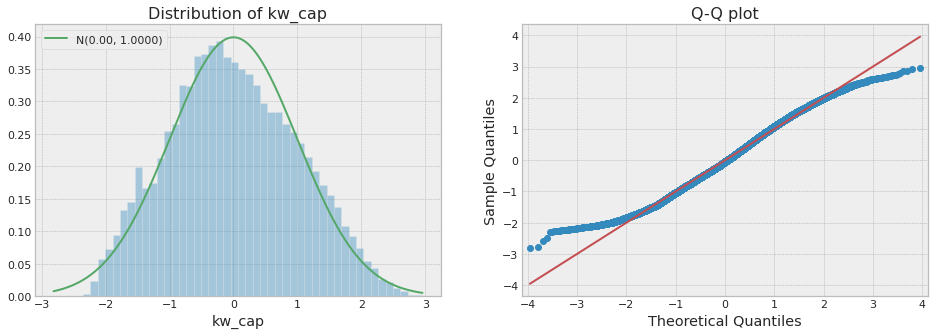

In [ ]:
import scipy.stats as scs

r_range = np.linspace(min(df1_stdard['kw_cap'].dropna()), max(df1_stdard['kw_cap'].dropna()), num=1000)
mu = df1_stdard['kw_cap'].dropna().mean()
sigma = df1_stdard['kw_cap'].dropna().std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

#Plot the histogram and the Q-Q plot
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# histogram
sns.distplot(df1_stdard['kw_cap'].dropna(), kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of kw_cap', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
import statsmodels.api as sm
qq = sm.qqplot(df1_stdard['kw_cap'].dropna().values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()